# Fit model to data
We will fit a `Polyclonal` model to the RBD antibody mix we simulated.

First, we read in that simulated data.
Recall that we simulated both "exact" and "noisy" data, with several average per-library mutations rates, and at six different concentrations.
Here we analyze the noisy data for the library with an average of 2 mutations per gene, measured at three different concentrations, as this represents a fairly realistic representation of a real experiment:

In [1]:
import pandas as pd

import polyclonal

noisy_data = (
    pd.read_csv("RBD_variants_escape_noisy.csv", na_filter=None)
    .query('library == "avg2muts"')
    .query("concentration in [0.25, 1, 4]")
    .reset_index(drop=True)
)

noisy_data

,library,barcode,concentration,prob_escape,aa_substitutions,IC90
0,avg2muts,AAAAAGCACAGTACAC,0.25,0.05044,,0.1128
1,avg2muts,AAAAAGCGAACAGATC,0.25,0.14310,,0.1128
2,avg2muts,AAAACAGCGCGCACCG,0.25,0.05452,,0.1128
3,avg2muts,AAAACGACCCATCCGC,0.25,0.08473,,0.1128
4,avg2muts,AAAACGCGATCACCTT,0.25,0.04174,,0.1128
...,...,...,...,...,...,...
89995,avg2muts,CCGGGTACTAAAAAGG,0.25,0.06873,Y508W,0.2285
89996,avg2muts,AACGGTTGCTTATAGA,1.00,0.01435,Y508W,0.2285
89997,avg2muts,CCGGGTACTAAAAAGG,1.00,0.01787,Y508W,0.2285
89998,avg2muts,AACGGTTGCTTATAGA,4.00,0.03754,Y508W,0.2285


Initialize a `Polyclonal` model with these data, including three epitopes.
We know from [prior work](https://www.nature.com/articles/s41467-021-24435-8) the three most important epitopes and a key mutation in each, so we use this prior knowledge to "seed" initial guesses that assign large escape values to a key site in each epitope:

 - site 417 for class 1 epitope, which is often the least important
 - site 484 for class 2 epitope, which is often the dominant one
 - site 444 for class 3 epitope, which is often the second most dominant one

In [2]:
poly_abs = polyclonal.Polyclonal(
    data_to_fit=noisy_data,
    activity_wt_df=pd.DataFrame.from_records(
        [
            ("1", 1.0),
            ("2", 3.0),
            ("3", 2.0),
        ],
        columns=["epitope", "activity"],
    ),
    site_escape_df=pd.DataFrame.from_records(
        [
            ("1", 417, 10.0),
            ("2", 484, 10.0),
            ("3", 444, 10.0),
        ],
        columns=["epitope", "site", "escape"],
    ),
    data_mut_escape_overlap="fill_to_data",
)

Now fit the `Polyclonal` model using the default optimization settings and logging output every 100 steps.
Note how the fitting first just fits a site level model to estimate the average effects of mutations at each site, and then fits the full model:

In [3]:
# NBVAL_IGNORE_OUTPUT
opt_res = poly_abs.fit(logfreq=100)

# First fitting site-level model.
# Starting optimization of 522 parameters at Mon Jun 27 14:30:39 2022.
         step     time_sec         loss     fit_loss   reg_escape   reg_spread reg_activity
            0     0.038764       9392.9       9386.6      0.59403            0       5.7092
          100       3.7233       1388.1       1375.8       6.7496            0       5.5503
          200       7.0377       1367.8       1354.3       7.9382            0       5.6055
          300       10.531       1356.9       1342.1       9.1962            0       5.6172
          400       13.992       1352.1       1336.4       10.092            0       5.6286
          500       17.249       1347.1       1330.4       11.155            0       5.5935
          600       20.502       1345.5       1328.3       11.545            0       5.5962
          700       23.689         1344       1326.5       11.894            0       5.6011
          800       26.945       1343.4       1325.7       12.109  

We can now visualize the resulting fits for the activity values and compare them to the "true" activity values used to simulate the data.

In [4]:
# NBVAL_IGNORE_OUTPUT
poly_abs.activity_wt_barplot()

alt.Chart(...)

In [5]:
import altair as alt

true_activities = pd.read_csv("RBD_activity_wt_df.csv")


activity_wt_comparison = (
    pd.concat(
        [
            poly_abs.activity_wt_df.rename(columns={'activity':'predicted'}), 
             true_activities.rename(columns={'activity':'actual'}).drop(columns='epitope')
        ], 
    axis=1)
).melt(id_vars=['epitope'], value_vars=['actual', 'predicted'], var_name='value_type', value_name='wildtype activity')

alt.Chart(activity_wt_comparison).mark_bar(size=35).encode(
    x='value_type:O',
    y='wildtype activity:Q',
    color=alt.Color('epitope:N', scale=alt.Scale(range=['#1f77b4', '#ff7f0e', '#2ca02c'])),
    column='epitope:N',
    tooltip=['value_type', alt.Tooltip('wildtype activity', format=".3f"), 'epitope']
).properties(
    width=100,
    height=125
)

alt.Chart(...)

Similarly, we can visualize the resulting fits for the escape values, and compare them to the "true" escape values used to simulate the data.

In [6]:
# NBVAL_IGNORE_OUTPUT
poly_abs.mut_escape_lineplot()

alt.VConcatChart(...)

In [7]:
# NBVAL_IGNORE_OUTPUT
poly_abs.mut_escape_heatmap()

alt.VConcatChart(...)

For these simulated data, we can also see how well the fit model does on the "true" simulated values from a library with a different (higher) mutation rate.
We therefore read in the "exact" simulated data from a library with a different mutation rate:

In [8]:
exact_data = (
    pd.read_csv("RBD_variants_escape_exact.csv", na_filter=None)
    .query('library == "avg3muts"')
    .query("concentration in [0.25, 1, 0.5]")
    .reset_index(drop=True)
)

We will compare the true simulated IC90 values to those predicted by the fit model.
We make the comparison on a log scale, and clip IC90s at values >50 as likely to be way outside the dynamic range given the concentrations used:

Correlation (R^2) is 0.98


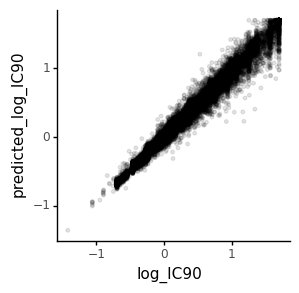

In [9]:
# NBVAL_IGNORE_OUTPUT

import numpy

from plotnine import *

max_ic90 = 50

# we only need the variants, not the concentration for the IC90 comparison
ic90s = (
    exact_data[["aa_substitutions", "IC90"]]
    .assign(IC90=lambda x: x["IC90"].clip(upper=max_ic90))
    .drop_duplicates()
)

ic90s = poly_abs.icXX(ic90s, x=0.9, col="predicted_IC90", max_c=max_ic90)

ic90s = ic90s.assign(
    log_IC90=lambda x: numpy.log10(x["IC90"]),
    predicted_log_IC90=lambda x: numpy.log10(x["predicted_IC90"]),
)

corr = ic90s["log_IC90"].corr(ic90s["predicted_log_IC90"]) ** 2
print(f"Correlation (R^2) is {corr:.2f}")

ic90_corr_plot = (
    ggplot(ic90s)
    + aes("log_IC90", "predicted_log_IC90")
    + geom_point(alpha=0.1, size=1)
    + theme_classic()
    + theme(figure_size=(3, 3))
)

_ = ic90_corr_plot.draw()
#ic90_corr_plot.save('IC90_pred_vs_actual.pdf', height=3.5, width=3.5)

Next we see how well the model predicts the variant-level escape probabilities $p_v\left(c\right)$, by reading in exact data from the simulations, and then making predictions of escape probabilities.
We both examine and plot the correlations:

Correlations (R^2) at each concentration:


,concentration,correlation (R^2)
0,0.25,0.99
1,0.50,0.99
2,1.00,0.98


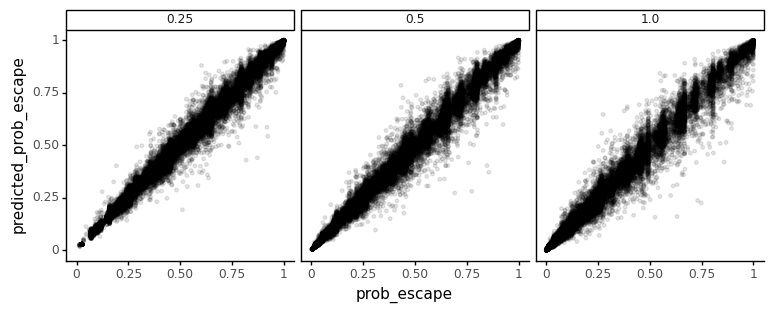

In [10]:
# NBVAL_IGNORE_OUTPUT

exact_vs_pred = poly_abs.prob_escape(variants_df=exact_data)

print(f"Correlations (R^2) at each concentration:")
display(
    exact_vs_pred.groupby("concentration")
    .apply(lambda x: x["prob_escape"].corr(x["predicted_prob_escape"]) ** 2)
    .rename("correlation (R^2)")
    .reset_index()
    .round(2)
)

pv_corr_plot = (
    ggplot(exact_vs_pred)
    + aes("prob_escape", "predicted_prob_escape")
    + geom_point(alpha=0.1, size=1)
    + facet_wrap("~ concentration", nrow=1)
    + theme_classic()
    + theme(figure_size=(3 * exact_vs_pred["concentration"].nunique(), 3))
)

_ = pv_corr_plot.draw()
#pv_corr_plot.save('pv_pred_vs_actual.pdf', height=3.5, width=10.5)

We also examine the correlation between the "true" and inferred mutation-escape values, $\beta_{m,e}$.
In general, it's necessary to ensure the epitopes match up for this type of comparison as it is arbitrary which epitope in the model is given which name.
But above we seeded the epitopes at the site level using `site_effects_df` when we initialized the `Polyclonal` object, so they match up with class 1, 2, and 3:

In [11]:
# NBVAL_IGNORE_OUTPUT

import altair as alt

mut_escape_pred = pd.read_csv("RBD_mut_escape_df.csv").merge(
    (
        poly_abs.mut_escape_df.assign(
            epitope=lambda x: "class " + x["epitope"].astype(str)
        ).rename(columns={"escape": "predicted escape"})
    ),
    on=["mutation", "epitope"],
    validate="one_to_one",
)

print("Correlation (R^2) between predicted and true values:")
corr = (
    mut_escape_pred.groupby("epitope")
    .apply(lambda x: x["escape"].corr(x["predicted escape"]) ** 2)
    .rename("correlation (R^2)")
    .reset_index()
)
display(corr.round(2))

# for testing since we nbval ignore cell output
assert (
    numpy.allclose(
        corr["correlation (R^2)"], numpy.array([0.63, 0.91, 0.85]), atol=0.02
    )
    == True
)

corr_chart = (
    alt.Chart(mut_escape_pred)
    .encode(
        x="escape",
        y="predicted escape",
        color=alt.Color("epitope", scale=alt.Scale(range=['#1f77b4', '#ff7f0e', '#2ca02c'])),
        tooltip=["mutation", "epitope"],
    )
    .mark_point(opacity=0.5)
    .properties(width=250, height=250)
    .facet(column="epitope")
    .resolve_scale(
        x="independent",
        y="independent",
    )
)

corr_chart

Correlation (R^2) between predicted and true values:


,epitope,correlation (R^2)
0,class 1,0.63
1,class 2,0.91
2,class 3,0.85


alt.FacetChart(...)

The correlations are strongest for the dominant epitope (class 2), which makes sense as this will drive the highest escape signal.